  **MCE vs. Logistic Regression**

Implementation of the minimum classification error (MCE) method to learn a binary classifier to classify two digits ('7' vs. '9') in the MNIST data set (https://www.kaggle.com/datasets/oddrationale/mnist-in-csv) is as follows below.

Its performance is compared with that of logistic regression and the best results in the heldout test data of these two digits are highlighted.

Processing file 1Jf2XqGR7y1fzOZNKLJiom7GmZZUzXhfs t10k-images-idx3-ubyte
Processing file 1qiYu9dW3ZNrlvTFO5fI4qf8Wtr8K-pCu t10k-labels-idx1-ubyte
Processing file 1SnWvBcUETRJ53rEJozFUUo-hOQFPKxjp train-images-idx3-ubyte
Processing file 1kKEIi_pwVHmabByAnwZQsaMgro9XiBFE train-labels-idx1-ubyte

9Training Logistic Regression9
[LR] epoch=01 loss=0.1530 (train=0.951, test=0.953)
[LR] epoch=02 loss=0.1375 (train=0.953, test=0.955)
[LR] epoch=03 loss=0.1310 (train=0.956, test=0.957)
[LR] epoch=04 loss=0.1271 (train=0.958, test=0.959)
[LR] epoch=05 loss=0.1234 (train=0.958, test=0.959)
[LR] epoch=06 loss=0.1228 (train=0.959, test=0.957)
[LR] epoch=07 loss=0.1205 (train=0.959, test=0.961)
[LR] epoch=08 loss=0.1179 (train=0.960, test=0.962)
[LR] epoch=09 loss=0.1170 (train=0.960, test=0.960)
[LR] epoch=10 loss=0.1148 (train=0.961, test=0.960)
[LR] epoch=11 loss=0.1141 (train=0.962, test=0.961)
[LR] epoch=12 loss=0.1133 (train=0.962, test=0.961)
[LR] epoch=13 loss=0.1128 (train=0.962, test=0.962

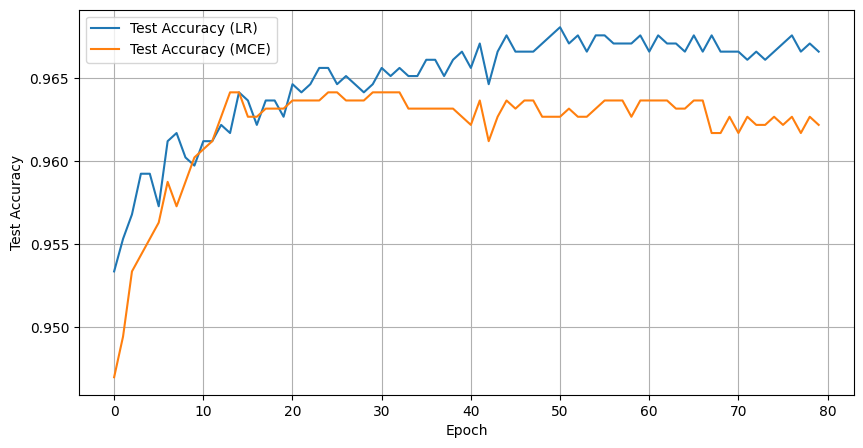

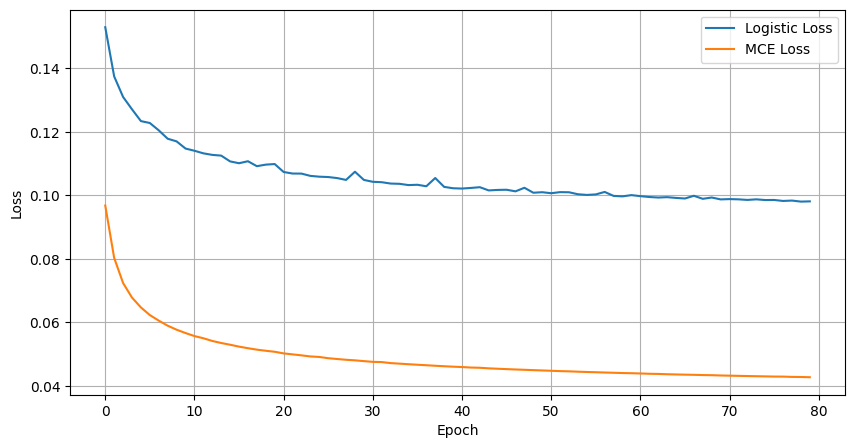

In [ ]:
!pip install python_mnist matplotlib gdown > /dev/null

import numpy as np
import matplotlib.pyplot as plt
from mnist import MNIST

# Download MNIST
!gdown --folder https://drive.google.com/drive/folders/1r20aRjc2iu9O3kN3Xj9jNYY2uMgcERY1 2> /dev/null


# Load and Prepare Data

mnist_loader = MNIST('MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()

X_train = np.array(train_data, dtype=float)
y_train = np.array(train_label)
X_test = np.array(test_data, dtype=float)
y_test = np.array(test_label)

# Select digits 7 and 9
digits = [7, 9]
train_mask = np.isin(y_train, digits)
test_mask = np.isin(y_test, digits)

X_train = X_train[train_mask] / 255.0
X_test = X_test[test_mask] / 255.0
y_train = y_train[train_mask]
y_test = y_test[test_mask]

# Map labels: 7 → +1, 9 → -1
y_train = np.where(y_train == 7, 1, -1)
y_test = np.where(y_test == 7, 1, -1)

# Add bias column
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# Optimizer and helper functions

class Optimizer():
    def __init__(self, lr, annealing_rate, batch_size, max_epochs):
        self.lr = lr
        self.annealing_rate = annealing_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#  Logistic Regression (baseline)

def logistic_regression_gd(X, y, X2, y2, op):
    n = X.shape[0]
    w = np.zeros(X.shape[1])
    lr = op.lr

    #vectors initialized with zeros
    errorsA = np.zeros(op.max_epochs)
    errorsB = np.zeros(op.max_epochs)
    errorsC = np.zeros(op.max_epochs)

    for epoch in range(op.max_epochs):
        indices = np.random.permutation(n)
        for batch_start in range(0, n, op.batch_size):
            X_batch = X[indices[batch_start:batch_start + op.batch_size]]
            y_batch = y[indices[batch_start:batch_start + op.batch_size]]

            w_grad = X_batch.T @ (y_batch * sigmoid(y_batch * (X_batch @ w)) - y_batch) / X_batch.shape[0]
            w -= lr * w_grad

        predict = np.sign(X @ w)
        predict2 = np.sign(X2 @ w)
        errorsA[epoch] = np.mean(predict == y)
        errorsB[epoch] = np.mean(predict2 == y2)
        errorsC[epoch] = -np.mean(np.log(sigmoid(y * (X @ w))))
        lr *= op.annealing_rate

        print(f"[LR] epoch={epoch+1:02d} loss={errorsC[epoch]:.4f} (train={errorsA[epoch]:.3f}, test={errorsB[epoch]:.3f})")

    return w, errorsA, errorsB, errorsC

# Minimum Classification Error (MCE)

def logistic_regression_mce(X, y, X2, y2, op):
    n = X.shape[0]
    w = np.zeros(X.shape[1])
    lr = op.lr
    errorsA = np.zeros(op.max_epochs)
    errorsB = np.zeros(op.max_epochs)
    errorsC = np.zeros(op.max_epochs)

    for epoch in range(op.max_epochs):
        indices = np.random.permutation(n)
        for batch_start in range(0, n, op.batch_size):
            X_batch = X[indices[batch_start:batch_start + op.batch_size]]
            y_batch = y[indices[batch_start:batch_start + op.batch_size]]

            # Using w' = -w, gradient becomes
            w_prime = -w

            # for each i in the batch, z is y_i w'^T x_i
            z = y_batch * (X_batch @ w_prime)

            # where b is the batch size, ∇_w' = 1/b[y_i * σ(y_i w'^T x_i) * (1 - σ(y_i w'^T x_i)) * x_i ]
            grad_w_prime = (X_batch.T @ ((y_batch * sigmoid(z) * (1 - sigmoid(z))).reshape(-1, 1))) / X_batch.shape[0]

            # Since w' = -w, we have ∇_w = -∇_w'
            grad_w = -grad_w_prime.flatten()
            w -= lr * grad_w

        # for learning curve C
        # MCE "loss" = mean(l(-y_i w^T x_i))
        errorsC[epoch] = np.mean(sigmoid(-y * (X @ w)))

        # for learning curve A
        predict = np.sign(X @ w)
        errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size

        # for learning curve B
        predict2 = np.sign(X2 @ w)
        errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

        lr *= op.annealing_rate

        print(f"[MCE] epoch={epoch+1:02d} loss={errorsC[epoch]:.4f} (train={errorsA[epoch]:.3f}, test={errorsB[epoch]:.3f})")

    return w, errorsA, errorsB, errorsC

# Run Experiments

op = Optimizer(lr=0.1, annealing_rate=0.99, batch_size=32, max_epochs=80)

print("\n9Training Logistic Regression9")
w_lr, A_lr, B_lr, C_lr = logistic_regression_gd(X_train, y_train, X_test, y_test, op)

print("\nTraining MCE")
w_mce, A_mce, B_mce, C_mce = logistic_regression_mce(X_train, y_train, X_test, y_test, op)

print("\nFinal Results")
print(f"Logistic Regression:")
print(f"  Test Accuracy: {B_lr[-1]:.3f}")
print(f"  Train Accuracy: {A_lr[-1]:.3f}")
print(f"  Final Loss: {C_lr[-1]:.4f}")

print(f"\nMCE:")
print(f"  Test Accuracy: {B_mce[-1]:.3f}")
print(f"  Train Accuracy: {A_mce[-1]:.3f}")
print(f"  Final Loss: {C_mce[-1]:.4f}")

#heldout test data result (testing on data not included in training set):
if B_lr[-1] > B_mce[-1]:
    print(f"BEST RESULT: Logistic Regression ({B_lr[-1]*100:.1f}%)")
    print(f"Outperforms MCE by {(B_lr[-1] - B_mce[-1])*100:.1f}")
elif B_mce[-1] > B_lr[-1]:
    print(f"BEST RESULT: MCE ({B_mce[-1]*100:.1f}%)")
    print(f"Outperforms Logistic Regression by {(B_mce[-1] - B_lr[-1])*100:.1f}")
else:
    print(f"BEST RESULT: Tie at {B_lr[-1]*100:.1f}%")

#plot figures
plt.figure(figsize=(10,5))
plt.plot(B_lr, label='Test Accuracy (LR)')
plt.plot(B_mce, label='Test Accuracy (MCE)')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(C_lr, label='Logistic Loss')
plt.plot(C_mce, label='MCE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()